In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
plt.rcParams['figure.figsize'] = [17, 21]

In [2]:
# Constants
gamma = 5./3.
k_b = 1.380649e-16

In [24]:
# Setting grids
def setup_grid():
    global xmin, xmax, ng, nx, dx, dy, dz, dV, ilo, ihi
    global rho, P, e, T
    global u, w, f_rho, f_e
    
    xmin = 0.0
    xmax = 1.0

    ng = 2 # ghost cells
    nx = 100 # number of cells
    dx = dy = (xmax - xmin)/nx
    dz = 1.
    dV = dx*dy*dz

    ilo = ng
    ihi = ng+nx#-1

    rho = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    P = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    e = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    T = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

    u = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    w = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

    f_rho = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_e = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

In [17]:
def fill_ICs(type="shock"):
    
    global rho, P, e, T 
    global u, w, f_rho, f_e
    
    if type == "shock": # 1+1d shock tube
        center = int(nx/2+ng)
        left = center - 10
        right = center + 10
        
        rho[ilo:ihi,ilo:ihi] = 0.1
        P[ilo:ihi,ilo:ihi] = 0.125
        
        rho[left:right,left:right] = 1.0
        P[left:right,left:right] = 1.0
        
        #u[:,ilo:ilo+20] = 1.0
        
    else:
        print("unknown type")
        
    e = P/(gamma-1.)
    T = (gamma-1.)*(rho*dV*e)/k_b

In [18]:
def colormaps():
    fig, axis = plt.subplots(3, 2)

    axis[0,0].pcolormesh(rho, cmap=plt.cm.jet, vmin=np.min(rho), vmax=np.max(rho))
    axis[0,0].set_title('Density')
    fig.colorbar(axis[0,0].pcolormesh(rho, cmap=plt.cm.jet, vmin=np.min(rho), vmax=np.max(rho)), ax=axis[0, 0])
    
    axis[0,1].pcolormesh(P, cmap=plt.cm.jet, vmin=np.min(P), vmax=np.max(P))
    axis[0,1].set_title('Pressure')
    fig.colorbar(axis[0,1].pcolormesh(P, cmap=plt.cm.jet, vmin=np.min(P), vmax=np.max(P)), ax=axis[0, 1])
    
    axis[1,0].pcolormesh(e, cmap=plt.cm.jet, vmin=np.min(e), vmax=np.max(e))
    axis[1,0].set_title('Energy')
    fig.colorbar(axis[1,0].pcolormesh(e, cmap=plt.cm.jet, vmin=np.min(e), vmax=np.max(e)), ax=axis[1, 0])
    
    axis[1,1].pcolormesh(T, cmap=plt.cm.jet, vmin=np.min(T), vmax=np.max(T))
    axis[1,1].set_title('Temperature')
    fig.colorbar(axis[1,1].pcolormesh(T, cmap=plt.cm.jet, vmin=np.min(T), vmax=np.max(T)), ax=axis[1, 1])
    
    axis[2,0].pcolormesh(u, cmap=plt.cm.jet, vmin=np.min(u), vmax=np.max(u))
    axis[2,0].set_title('x velocity')
    fig.colorbar(axis[2,0].pcolormesh(u, cmap=plt.cm.jet, vmin=np.min(u), vmax=np.max(u)), ax=axis[2, 0])
                 
    axis[2,1].pcolormesh(w, cmap=plt.cm.jet, vmin=np.min(w), vmax=np.max(w))
    axis[2,1].set_title('y velocity')
    fig.colorbar(axis[2,1].pcolormesh(w, cmap=plt.cm.jet, vmin=np.min(w), vmax=np.max(w)), ax=axis[2, 1])

In [53]:
def apply_BCs(apply):
#    global rho, P, e, T, u, w 
#    global u_temp
    
#    variables = [apply]#rho, P, e, T, u, w, u_temp]
    
    for var_array in [apply]:
        
        # periodic boundary condition for horizontal
        var_array[:,ilo-2] = var_array[:,ihi-1]
        var_array[:,ilo-1] = var_array[:,ihi-2]
        var_array[:,ihi+1] = var_array[:,ilo]
        var_array[:,ihi] = var_array[:,ilo+1]
        
        # reflecting boundary condition for vertical
        var_array[ilo-2,:] = var_array[ilo+1,:]
        var_array[ilo-1,:] = var_array[ilo,:]
        var_array[ihi,:] = var_array[ihi-1,:]
        var_array[ihi+1,:] = var_array[ihi-2,:]
        
# put 

In [20]:
def timestep():
    global dt
    cs = np.sqrt(gamma*P/rho)
    du = 1
    dw = 1
    q = 1
    C0 = 0.5
    dt_1 = dx/(cs+np.abs(u)) #1/cs*np.min(dx,dy)
    dt_2 = dy/(cs+np.abs(w)) #dx/np.abs(u)
    dt_3 = dx/(4.*q*q*np.abs(du)) #dy/np.abs(w)
    dt_4 = dy/(4.*q*q*np.abs(dw)) #np.min(dx/(4.q*q*np.abs(du)),dy/(4.q*q*np.abs(dw)))
    dt = C0*min(np.min(dt_1),np.min(dt_2),np.min(dt_3),np.min(dt_4))
    # dt = C0*np.max(dt_1**(-2.0)+dt_2**(-2.0)+dt_3**(-2.0)+dt_4**(-2.0))**(-0.5)

In [30]:
#def solve_source():

def update_velocity():
    global u, w

    u_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    w_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            u_temp[k,j] = u[k,j] - 2*dt*(P[k,j+1]-P[k,j-1])/(dx*(rho[k,j]+rho[k,j-1]))
            w_temp[k,j] = w[k,j] - 2*dt*(P[k+1,j]-P[k-1,j])/(dy*(rho[k,j]+rho[k-1,j]))

    u = u_temp
    w = w_temp

def update_energy():
    global P, e
    global P_temp_p, P_temp_half, e_temp

    e_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    e_temp_p = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    P_temp_p = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    P_temp_half = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

    for k in range(ilo,ihi):
        for j in range(ilo,ihi):        
            e_temp_p[k,j] = e[k,j] - dt*P[k,j]*((u[k,j+1]-u[k,j])/dx + (w[k+1,j]-w[k,j])/dy)
            P_temp_p[k,j] = e_temp_p[k,j]/(gamma-1.)
            P_temp_half[k,j] = 0.5*(P[k,j] + P_temp_p[k,j])
            e_temp[k,j] = e[k,j] - dt*P_temp_half[k,j]*((u[k,j+1]-u[k,j])/dx + (w[k+1,j]-w[k,j])/dy)

    #P = 
    e = e_temp


def apply_artificial_viscosity():
    global u, w, e, q

    q = 1.0

    def obtain_Q():
        global Qx, Qy

        Qx = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
        Qy = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

        for k in range(ilo,ihi):
            for j in range(ilo,ihi):        
                if u[k,j+1]-u[k,j] < 0.:
                    Qx[k,j] = q**2.*rho[k,j]*(u[k,j+1]-u[k,j])**2.
                else:
                    Qx[k,j] = 0.

        for k in range(ilo,ihi):
            for j in range(ilo,ihi):
                if w[k+1,j]-w[k,j] < 0.:
                    Qy[k,j] = q**2.*rho[k,j]*(w[k+1,j]-w[k,j])**2.
                else:
                    Qy[k,j] =  0.

    obtain_Q()

    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            u_temp[k,j] = u[k,j] - 2*dt*(Qx[k,j+1]-Qx[k,j-1])/(dx*(rho[k,j]-rho[k,j-1]))
            w_temp[k,j] = w[k,j] - 2*dt*(Qy[k+1,j]-Qy[k-1,j])/(dy*(rho[k,j]-rho[k-1,j]))
            e_temp[k,j] = e[k,j] - dt*Qx[k,j]*(u[k,j+1]-u[k,j])/dx + Qy[k,j]*(w[k+1,j]-w[k,j])/dy

    u = u_temp
    w = w_temp
    e = e_temp

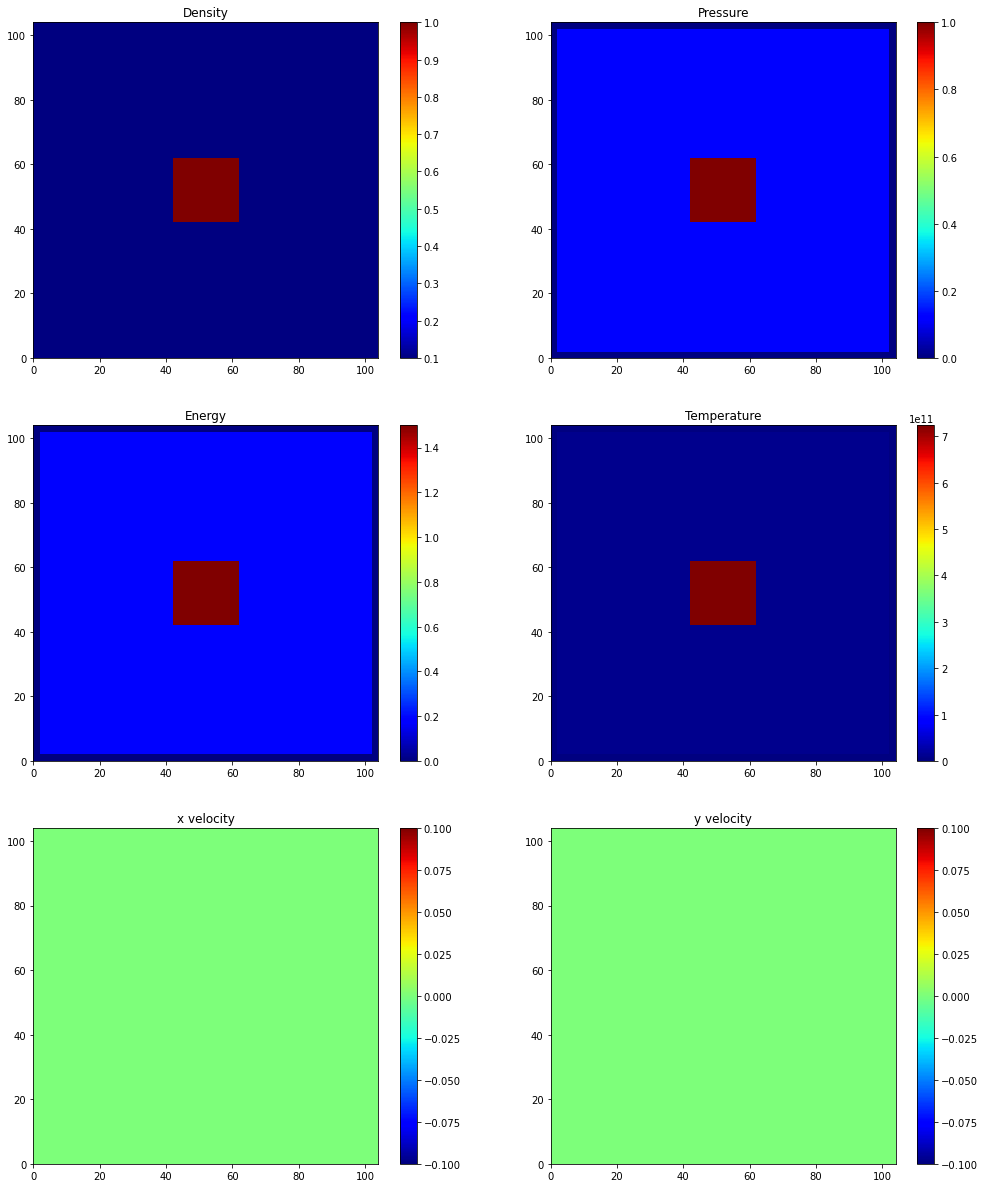

In [59]:
setup_grid()
fill_ICs(type="shock")
apply_BCs(rho)
#timestep()
#update_velocity()
#update_energy()
#apply_artificial_viscosity()

#solve_advection()
colormaps()
#timestep()
#print(dt)

In [ ]:
def solve_advection():

    Ax = dy*dz # Ax[j,k]
    Ay = dx*dz # Ay[j,k]
    
    def obtain_avg(method="donor"):
        global avg_rho_x, avg_rho_y, avg_e_x, avg_e_y
        global avg_ux, avg_uy, avg_wx, avg_wy
        
        if method == "donor": # use this for now
            avg_rho_x = rho
            avg_rho_y = rho
            avg_e_x = e
            avg_e_y = e
        elif method == "van Leer":
            avg_rho_x = rho
            avg_rho_y = rho
            avg_e_x = e
            avg_e_y = e
        else:
            print("not devloped yet")
    obtain_avg(method="donor")
    
    f_rho_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_rho_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    rho_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)

    f_e_x = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    f_e_y = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    mom_den_u_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    mom_den_u = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    mom_den_w_temp = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    mom_den_w = np.zeros([nx+2*ng,nx+2*ng],dtype=np.float64)
    
    
    for k in range(ilo,ihi):
        for j in range(ilo,ihi):
            f_rho_x[k,j] = u[k,j]*avg_rho_x*Ax
            f_rho_y[k,j] = w[k,j]*avg_rho_y*Ay

            rho_temp[k,j] = rho[k,j] - dt/dV * (f_rho_x[k,j+1]-f_rho_x[k,j])
            rho[k,j] = rho_temp[k,j] - dt/dV * (f_rho_y[k+1]-f_rho_y[k,j])

            f_e_x[k,j] = avg_e_x*f_rho_x[k,j]
            f_e_y[k,j] = avg_e_y*f_rho_y[k,j]

            e_temp[k,j] = e[k,j] - dt/dV * (f_e_x[k,j+1]-f_e_x[k,j])
            e[k,j] = e_temp[k,j] - dt/dV * (f_e_y[k+1,j]-f_e_y[k,j])

            f_u_x[k,j] = avg_ux*0.5*(f_rho_x[k,j-1]+f_rho_x[k,j])
            f_u_y[k,j] = avg_uy*0.5*(f_rho_y[k,j-1]+f_rho_y[k,j])

            f_w_x[k,j] = avg_wx*0.5*(f_rho_x[k-1,j]+f_rho_x[k,j])
            f_w_y[k,j] = avg_wy*0.5*(f_rho_y[k-1,j]+f_rho_y[k,j])

            mom_den_u_temp[k,j] = rho[k,j]*u[k,j] - dt/dV*(f_u_x[k,j+1]-f_u_x[k,j])
            mom_den_u[k,j] = mom_den_u_temp[k,j] - dt/dV*(f_u_y[k+1,j]-f_u_y[k,j])

            mom_den_w_temp[k,j] = rho[k,j]*w[k,j] - dt/dV*(f_w_x[k,j+1]-f_w_x[k,j])
            mom_den_w[k,j] = mom_den_w_temp[k,j] - dt/dV*(f_w_y[k+1,j]-f_w_y[k,j])

            u[k,j] = mom_den_u[k,j]/rho[k,j]
            w[k,j] = mom_den_w[k,j]/rho[k,j]        

            f_rho_x[j,k] = u[j,k]*avg_rho*Ax
            f_rho_y[j,k] = w[j,k]*avg_rho*Ay

            rho_temp[j,k] = rho[j,k] - dt/dV * (f_rho_x[j+1,k]-f_rho_x[j,k])
            rho[j,k] = rho_temp[j,k] - dt/dV * (f_rho_y[j,k+1]-f_rho_y[j,k])

            f_e_x[j,k] = avg_e*f_rho_x[j,k]
            f_e_y[j,k] = avg_e*f_rho_y[j,k]

            e_temp[j,k] = e[j,k] - dt/dV * (f_e_x[j+1,k]-f_e_x[j,k])
            e[j,k] = e_temp[j,k] - dt/dV * (f_e_y[j,k+1]-f_e_y[j,k])

            f_u_x[j,k] = avg_ux*0.5*(f_rho_x[j-1,k]+f_rho_x[j,k])
            f_u_y[j,k] = avg_uy*0.5*(f_rho_y[j-1,k]+f_rho_y[j,k])

            f_w_x[j,k] = avg_wx*0.5*(f_rho_x[j,k-1]+f_rho_x[j,k])
            f_w_y[j,k] = avg_wy*0.5*(f_rho_y[j,k-1]+f_rho_y[j,k])

            mom_den_u_temp[j,k] = rho[j,k]*u[j,k] - dt/dV*(f_u_x[j+1,k]-f_u_x[j,k])
            mom_den_u[j,k] = mom_den_u_temp[j,k] - dt/dV*(f_u_y[j,k+1]-f_u_y[j,k])

            mom_den_w_temp[j,k] = rho[j,k]*w[j,k] - dt/dV*(f_w_x[j+1,k]-f_w_x[j,k])
            mom_den_w[j,k] = mom_den_w_temp[j,k] - dt/dV*(f_w_y[j,k+1]-f_w_y[j,k])

            u[j,k] = mom_den_u[j,k]/rho[j,k]
            w[j,k] = mom_den_w[j,k]/rho[j,k]

solve_advection()
u

ERROR! Session/line number was not unique in database. History logging moved to new session 69


## Main program

In [ ]:
# setup the grid

# solve advection
## set dt
## set fill_IC
### while loop t < tmax
#### apply_BCs
#### calculating source
#### apply BCs
##### solve advection
### do again

## Implementing other's code to test animation

In [ ]:
# We use numpy (for array related operations) and matplotlib (for plotting) 
# because they will help us a lot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

plate_length = 50
max_iter_time = 1000

alpha = 2.0
delta_x = 1

# Calculated params
delta_t = (delta_x ** 2)/(4 * alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)

# Initialize solution: the grid of u(k, i, j)
u = np.empty((max_iter_time, plate_length, plate_length))

# Initial condition everywhere inside the grid
u_initial = 0.0

# Boundary conditions (fixed temperature)
u_top = 100.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0

# Set the initial condition
u.fill(u_initial)

# Set the boundary conditions
u[:, (plate_length-1):, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (plate_length-1):] = u_right

In [ ]:
def calculate(u):
  for k in range(0, max_iter_time-1, 1):
    for i in range(1, plate_length-1, delta_x):
      for j in range(1, plate_length-1, delta_x):
        u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]
  
  return u

In [ ]:
def plotheatmap(u_k, k):
  # Clear the current plot figure
  plt.clf()
  plt.title(f"Temperature at t = {k*delta_t:.3f} unit time")
  plt.xlabel("x")
  plt.ylabel("y")
  
  # This is to plot u_k (u at time-step k)
  plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=100)
  plt.colorbar()
  
  return plt

In [ ]:
def animate(k):
  plotheatmap(u[k], k)

anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False)
#anim.save("heat_equation_solution.gif")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

print("2D heat equation solver")

plate_length = 50
max_iter_time = 750

alpha = 2
delta_x = 1

delta_t = (delta_x ** 2)/(4 * alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)

# Initialize solution: the grid of u(k, i, j)
u = np.empty((max_iter_time, plate_length, plate_length))

# Initial condition everywhere inside the grid
u_initial = 0

# Boundary conditions
u_top = 100.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0

# Set the initial condition
u.fill(u_initial)

# Set the boundary conditions
u[:, (plate_length-1):, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (plate_length-1):] = u_right

def calculate(u):
    for k in range(0, max_iter_time-1, 1):
        for i in range(1, plate_length-1, delta_x):
            for j in range(1, plate_length-1, delta_x):
                u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]

    return u

def plotheatmap(u_k, k):
    # Clear the current plot figure
    plt.clf()

    plt.title(f"Temperature at t = {k*delta_t:.3f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=100)
    plt.colorbar()

    return plt

# Do the calculation here
u = calculate(u)

def animate(k):
    plotheatmap(u[k], k)

anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False)
anim.save("heat_equation_solution.gif")#,writer='Pillow', fps=2)

print("Done!")